# Poisson Processes

In addition to what’s in Anaconda, this lecture will need the following libraries:

In [1]:
!pip install quantecon

## Overview

Counting processes count the number of "arrivals" occurring by a given time
(e.g., the number of visitors to a website, the number of customers arriving at a restaurant, etc.)

Counting processes become Poisson processes when the time interval between
arrivals is IID and exponentially distributed.

Exponential distributions and Poisson processes have deep connections to
continuous time Markov chains.

For example, Poisson processes are one of the simplest nontrivial examples of
a continuous time Markov chain.

In addition, when continuous time Markov chains jump between states, the time
between jumps is *necessarily* exponentially distributed.

In discussing Poisson processes, we will use the following imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import njit
from scipy.special import factorial, binom

## Counting Processes

Let's start with the general case of an arbitrary counting process.


### Jumps and Counts

Let $(J_k)$ be an increasing sequence of nonnegative random variables
satisfying  $J_k \to \infty$ with probability one.

For example, $J_k$ might be the time the $k$-th customer arrives at a shop.

Then 

$$
    N_t := \sum_{k \geq 0} k \mathbb{1} \{ J_k \leq t < J_{k+1} \}
$$ (defcount)

is the number of customers that have visited by time $t$.



The next figure illustrate the definition of $N_t$ for a given jump sequence $\{J_k\}$.

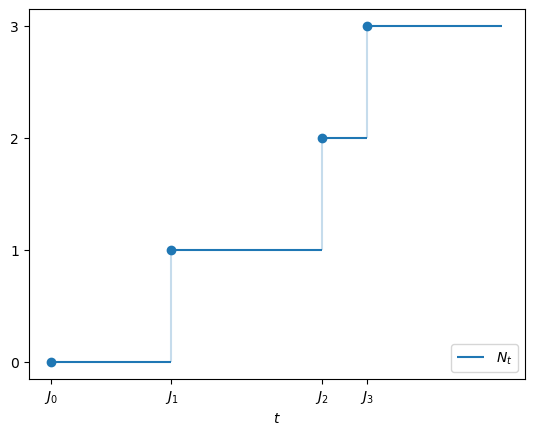

In [3]:
Ks = 0, 1, 2, 3
Js = 0, 0.8, 1.8, 2.1, 3
n = len(Ks)

fig, ax = plt.subplots()

ax.plot(Js[:-1], Ks, 'o')
ax.hlines(Ks, Js[:-1], Js[1:], label='$N_t$')
ax.vlines(Js[:-1], (0, Ks[0], Ks[1], Ks[2]), Ks, alpha=0.25)

ax.set(xticks=Js[:-1],
       xticklabels=[f'$J_{k}$' for k in range(n)],
       yticks=(0, 1, 2, 3),
       xlabel='$t$')

ax.legend(loc='lower right')
plt.show()

An alternative but equivalent definition is

$$
    N_t := \max \{k \geq 0 \,|\, J_k \leq t \}
$$

As a function of $t$, the process $N_t$ is called a **counting process**.

The jump times $(J_k)$ are sometimes called **arrival times** and the
intervals $J_k - J_{k-1}$ are called **wait times** or **holding times**.




### Exponential Holding Times

A Poisson process is a counting process with independent exponential holding times.

In particular, suppose that the arrival times are given by $J_0 = 0$ and 

$$
    J_k := W_1 + \cdots W_k 
$$

where $(W_i)$ are IID exponential with some fixed rate $\lambda$.

Then the associated counting process $(N_t)$ is called a **Poisson process** with rate $\lambda$.

The rationale behind the name is that, for each $t > 0$, the random variable
$N_t$ has the Poisson distribution with parameter $t \lambda$.

In other words, 

$$ 
    \PP\{N_t = k\} 
    = e^{-t \lambda} \frac{(t \lambda)^k }{k!}
    \qquad (k = 0, 1, \ldots)
$$ (poissondist)

For example, since $N_t = 0$ if and only if $W_1 > t$, we have

$$ 
    \PP\{N_t =0\} 
    = \PP\{W_1 > t\}
    = e^{-t \lambda}
$$

and the right hand side agrees with {eq}`poissondist` when $k=0$.

This sets up a proof by induction, which is time consuming but not difficult
--- the details can be found in $\S29$ of {cite}`howard2017elements`.

Another way to show that $N_t$ is Poisson with rate $\lambda$ is to appeal to 
{prf:ref}`erlexp`.

We observe that

$$ 
    \PP\{N_t \leq n\} 
    = \PP\{J_{n+1} > t\} 
    = 1 - \PP\{J_{n+1} \leq t\}
$$

Inserting the expression for the Erlang CDF in {eq}`erlcdf` with shape $n+1$ and
rate $\lambda$, we obtain 

$$ 
    \PP\{N_t \leq n\} 
    = \sum_{k=0}^{n} \frac{(t \lambda )^k}{k!} e^{-t \lambda}
$$

This is the (integer valued) CDF for the Poisson distribution with parameter
$t \lambda$.

An exercise at the end of the lecture asks you to verify that $N_t$ is Poisson-$(t \lambda )$ informally via simulation.

The next figure shows one realization of a Poisson process $(N_t)$, with jumps
at each new arrival.

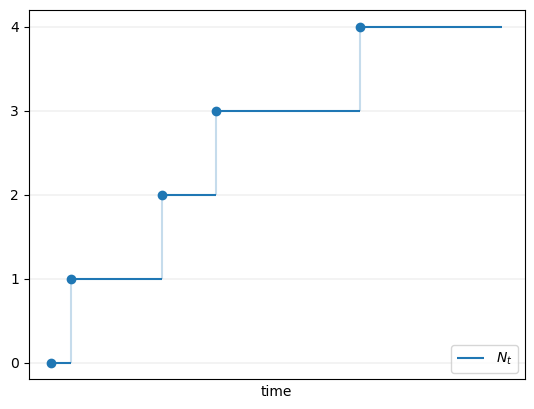

In [4]:
np.random.seed(1234)
T = 5
Ws = np.random.exponential(size=T)
Js = np.cumsum(Ws)
Ys = np.arange(T)

fig, ax = plt.subplots()

ax.plot(np.insert(Js, 0, 0)[:-1], Ys, 'o')
ax.hlines(Ys, np.insert(Js, 0, 0)[:-1], Js, label='$N_t$')
ax.vlines(Js[:-1], Ys[:-1], Ys[1:], alpha=0.25)

ax.set(xticks=[],
       yticks=range(Ys.max()+1),
       xlabel='time')

ax.grid(lw=0.2)
ax.legend(loc='lower right')
plt.show()

## Stationary Independent Increments

One of the defining features of a Poisson process is that it has stationary
and independent increments.

This is due to the memoryless property of exponentials.

It means that

1. the variables $\{N_{t_{i+1}} - N_{t_i}\}_{i \in I}$ are independent for any
   strictly increasing finite sequence $(t_i)_{i \in I}$ and
2. the distribution of $N_{t+h} - N_t$ depends on $h$ but not $t$.


A detailed proof can be found in Theorem 2.4.3 of {cite}`norris1998markov`.

Instead of repeating this, we provide some intuition from a discrete
approximation.

In the discussion below, we use the following well known fact:  If
$(\theta_n)$ is a sequence such that $n \theta_n$ converges, then

$$
    \text{Binomial}(n, \theta_n) 
    \approx
    \text{Poisson}(n \theta_n)
    \quad \text{for large } n
$$ (binpois)

(The exercises ask you to examine this claim visually.)

We now return to {ref}`the environment <geomtoexp>` where we linked the
geometric distribution to the exponential.

That is, we fix small $h > 0$ and let $t_i := ih$ for all $i \in \ZZ_+$.

Let $(V_i)$ be IID binary random variables with $\PP\{V_i = 1\} = h \lambda$ for some $\lambda > 0$.

Linking to our previous discussion, 

* either one or zero customers visits a shop at each $t_i$.
* $V_i = 1$ means that a customer visits at time $t_i$.
* Visits occur with probability $h \lambda$, which is proportional to the
  length of the interval between grid points.

We learned that the wait time until the first visit is
approximately exponential with rate $t \lambda$.

Since $(V_i)$ is IID, the same is true for the second wait time and so on.

Moreover, these wait times are independent, since they depend on separate
subsets of $(V_i)$.

Let $\hat N_t$ count the number of visits by time $t$, as shown in the next figure.

($V_i = 1$ is indicated by a vertical line at $t_i = i h$.)

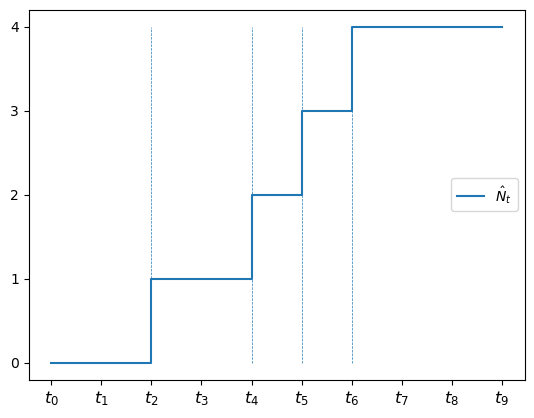

In [5]:
fig, ax = plt.subplots()
np.random.seed(1)
T = 10
p = 0.25
B = np.random.uniform(size=T) < p
N = np.cumsum(B)
m = N[-1]  # max of N

t_grid = np.arange(T)
t_ticks = [f'$t_{i}$' for i in t_grid]
ax.set_yticks(range(m+1))
ax.set_xticks(t_grid)
ax.set_xticklabels(t_ticks, fontsize=12)

ax.step(t_grid, np.insert(N, 0, 0)[:-1], label='$\hat N_t$')

for i in t_grid:
    if B[i]:
        ax.vlines((i,), (0,), (m,), ls='--', lw=0.5)

ax.legend(loc='center right')
plt.show()

We expect from the discussion above that $(\hat N_t)$ approximates a Poisson process.

This intuition is correct because, fixing $t$, letting $k := \max\{i \in
\ZZ_+ \,:\, t_i \leq t\}$ and applying {eq}`binpois`, we have

$$
    \hat N_t 
    = \sum_{i=1}^k V_i
    \sim \text{Binomial}(k, h \lambda)
    \approx
    \text{Poisson}(k h \lambda )
$$

Using the fact that $kh = t_k \approx t$ as $h \to 0$, we see
that $\hat N_t$ is approximately Poisson with rate $t \lambda$, just as we
expected.


This approximate construction of a Poisson process helps illustrate the
property of stationary independent increments.

For example, if we fix $s, t$, then $\hat N_{s + t} - \hat N_s$ is the number of visits
between $s$ and $s+t$, so that 

$$
    \hat N_{s+t} - \hat N_s
    = \sum_i V_i \mathbb 1\{ s \leq t_i < s + t \}
$$

Suppose there are $k$ grid points between $s$ and $s+t$, so that $t \approx
kh$.

Then

$$
    \hat N_{s+t} - \hat N_s
    \sim \text{Binomial}(k, h \lambda )
    \approx 
    \text{Poisson}(k h \lambda )
    \approx 
    \text{Poisson}(t\lambda)
$$

This illustrates the idea that, for a Poisson process $(N_t)$, we have

$$
   N_{s+t} - N_s 
   \sim  \text{Poisson}(t\lambda)
$$

In particular, increments are stationary (the distribution depends on $t$ but not $s$).

The approximation also illustrates independence of increments, since, in the
approximation, increments depend on separate subsets of $(V_i)$.




## Uniqueness

What other counting processes have stationary independent increments?

Remarkably, the answer is none: 

```{prf:theorem}  Characterization of Poisson Processes

If $(M_t)$ is a stochastic process supported on $\ZZ_+$ and starting at 0 with
the property that its increments are stationary and independent, then $(M_t)$ is a Poisson process.

```

In particular, there exists a $\lambda > 0$ such that

$$
    M_{s + t} - M_s
   \sim  \text{Poisson}(t\lambda)
$$

for any $s, t$.

The proof is similar to our earlier proof that the exponential distribution is
the only memoryless distribution.

Details can be found in Section 6.2 of {cite}`pardoux2008markov` or 
Theorem 2.4.3 of {cite}`norris1998markov`.

(restart_prop)=
### The Restarting Property

An important consequence of stationary independent increments is the
restarting property, which means that, when simulating, we can freely stop and
restart a Poisson process at any time:

```{prf:theorem} Poisson Processes can be Paused and Restarted
If $(N_t)$ is a Poisson process, $s > 0$ and 
$(M_t)$ is defined by $M_t = N_{s+t} - N_s$ for $t \geq 0$, then $(M_t)$ is a 
Poisson process independent of $(N_r)_{r \leq s}$.
```

```{prf:proof}
Independence of $(M_t)$ and $(N_r)_{r \leq s}$ follows from indepenence of the
increments of $(N_t)$.

In view of the uniqueness statement above, we can verify that $(M_t)$ is a
Poisson process by showing that $(M_t)$ starts at zero, takes values in 
$\ZZ_+$ and has stationary independent increments.

It is clear that $(M_t)$ starts at zero and takes values in $\ZZ_+$.

In addition, if we take any $t < t'$, then

$$
    M_{t'} - M_t = N_{s+t'} - N_{s + t}
   \sim  \text{Poisson}((t' - t) \lambda)
$$

Hence $(M_t)$ has stationary increments and, 
using the relation $M_{t'} - M_t = N_{s+t'} - N_{s + t}$ again,
the increments are independent as well.
    
We conclude that $(N_{s+t} - N_s)_{t \geq 0}$ is indeed a 
Poisson process independent of $(N_r)_{r \leq s}$.
```



## Exercises

```{exercise}
:label: poisson-ex-1

Fix $\lambda > 0$ and draw $\{W_i\}$ as IID exponentials with rate $\lambda$.

Set $J_n := W_1 + \cdots W_n$ with $J_0 = 0$ and
    $N_t := \sum_{n \geq 0} n \mathbb 1\{ J_n \leq t < J_{n+1} \}$.

Provide a visual test of the claim that $N_t$ is Poisson with parameter $t
\lambda$.

Do this by fixing $t = T$, generating many independent draws of $N_T$ and
comparing the empirical distribution of the sample with a Poisson
distribution with rate $T \lambda$.

Try first with $\lambda = 0.5$ and $T=10$.
```

```{solution-start} poisson-ex-1
:class: dropdown
```

Here is one solution.

The figure shows that the fit is already good with a modest sample size.

Increasing the sample size will further improve the fit.

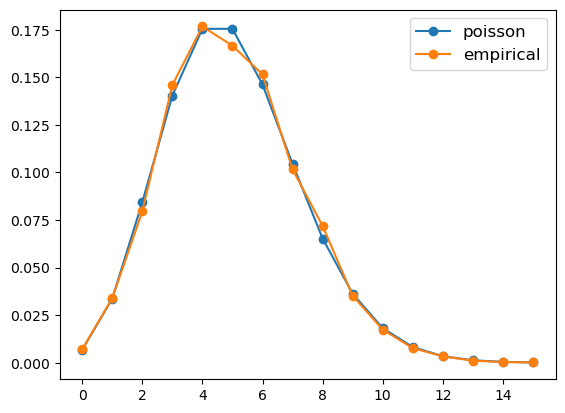

In [6]:
λ = 0.5
T = 10

def poisson(k, r):
    "Poisson pmf with rate r."
    return np.exp(-r) * (r**k) / factorial(k)

@njit
def draw_Nt(max_iter=1e5):
    J = 0
    n = 0
    while n < max_iter:
        W = np.random.exponential(scale=1/λ)
        J += W
        if J > T:
            return n
        n += 1

@njit
def draw_Nt_sample(num_draws):
    draws = np.empty(num_draws)
    for i in range(num_draws):
        draws[i] = draw_Nt()
    return draws


sample_size = 10_000
sample = draw_Nt_sample(sample_size)
max_val = sample.max()
vals = np.arange(0, max_val+1)

fig, ax = plt.subplots()

ax.plot(vals, [poisson(v, T * λ) for v in vals],
    marker='o', label='poisson')
ax.plot(vals, [np.mean(sample==v) for v in vals],
    marker='o', label='empirical')

ax.legend(fontsize=12)
plt.show()

```{solution-end}
```


```{exercise}
:label: poisson-ex-2

In the lecture we used the fact that $\Binomial(n, \theta) \approx \Poisson(n \theta)$ when $n$ is large and $\theta$ is small.

Investigate this relationship by plotting the distributions side by side.

Experiment with different values of $n$ and $\theta$.
```

```{solution-start} poisson-ex-2
:class: dropdown
```

Here is one solution.  It shows that the approximation is good when $n$ is
large and $\theta$ is small.

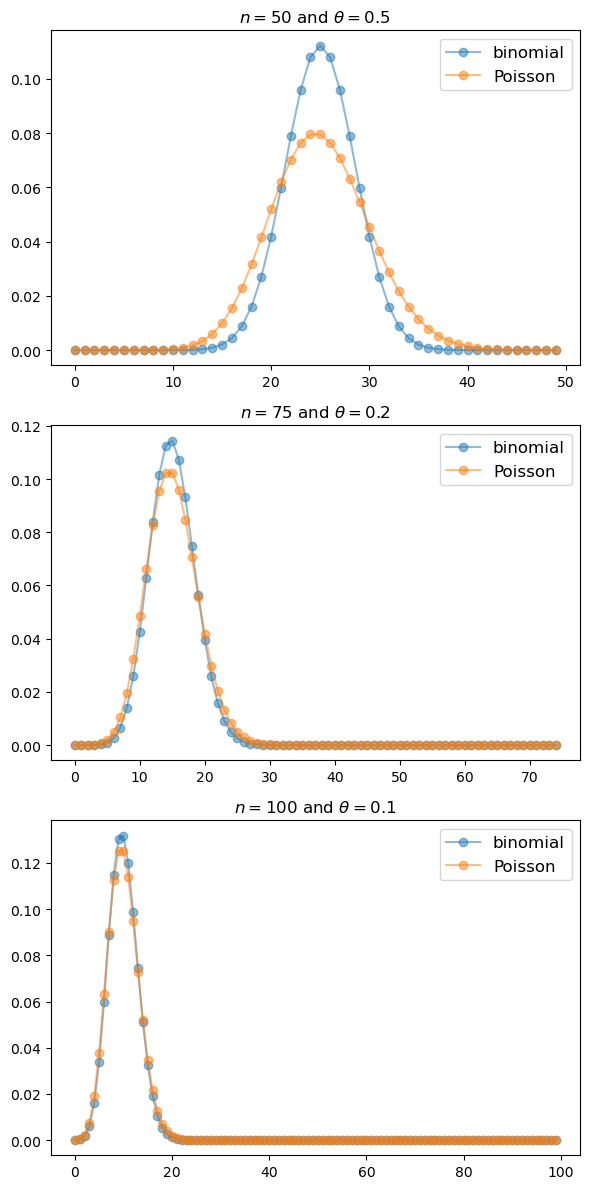

In [7]:
def binomial(k, n, p):
    # Binomial(n, p) pmf evaluated at k
    return binom(n, k) * p**k * (1-p)**(n-k)

θ_vals = 0.5, 0.2, 0.1

n_vals = 50, 75, 100

fig, axes = plt.subplots(len(n_vals), 1, figsize=(6, 12))

for n, θ, ax in zip(n_vals, θ_vals, axes.flatten()):

    k_grid = np.arange(n)
    binom_vals = [binomial(k, n, θ) for k in k_grid]
    poisson_vals = [poisson(k, n * θ) for k in k_grid]
    ax.plot(k_grid, binom_vals, 'o-', alpha=0.5, label='binomial')
    ax.plot(k_grid, poisson_vals, 'o-', alpha=0.5, label='Poisson')
    ax.set_title(f'$n={n}$ and $\\theta = {θ}$')
    ax.legend(fontsize=12)

fig.tight_layout()
plt.show()

```{solution-end}
```